In [29]:
# pip install -U memory_profiler

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import random
import enum
import time
from memory_profiler import profile
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Задание 1

Решить линейную регрессию — найти прямую, которая описывает зависимость

N - количество осей (размерность) <br>
M - количество точек <br>
minValue - минимальное значение для иксов <br>
maxValue - максимальное значение для иксов

In [31]:
N = 1
M = 30
minValue = 0
maxValue = 5
beta_1 = 0.9
beta_2 = 0.999
batch = random.randint(1, M)

class TypeOfOptimisation(enum.Enum):
    none = 0
    momentum = 1
    Nesterov = 2
    RMSProp = 3
    AdaGrad = 4
    Adam = 5

a = np.array([1, 2])
print(np.sqrt(a))

[1.         1.41421356]


In [32]:
def y_regression(B, X):
    return np.sum(X * B)


B_reg = []
for ind in range(N + 1):
    bi = random.randint(-maxValue, maxValue)
    B_reg.append(bi)
B_reg = np.array(B_reg, dtype='float64')
print(B_reg)
XM = []
YM = []
YR = []
for ind in range(M):
    X = [1]
    for j in range(N):
        X.append(ind)
    X = np.array(X)
    rand_delta = random.randint(-maxValue, maxValue)
    Y_act = y_regression(B_reg, X) + 0.5 * rand_delta
    YM.append(Y_act)
    XM.append(np.array(X))
XM = np.array(XM, dtype='float64')
YM = np.array(YM)

def runSGD(batch, typeOfOptimisation, withNormalization, lr, eps):
    B_start = np.array([0] * (N + 1), dtype='float64')
    YR = np.array([0] * M, dtype='float64')
    global calculations
    start = time.time()
    calculations = 0
    if withNormalization:
        X_norm = ZNormalization(XM)
        Y_norm = (YM - np.mean(YM)) / np.std(YM)
        BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
        BF_norm, \
        errors_norm, \
        YF_norm, \
        iterations = gradient_descent(batch,
                                      X_norm,
                                      Y_norm,
                                      YR,
                                      B_start,
                                      lr,
                                      eps,
                                      TypeOfOptimisation.none,
                                      with_normalization=True)
        print()
        print(errors_norm[0], errors_norm[len(errors_norm) - 1])
        print("batch:                   ", batch)
        print("actual coefficients:     ", BA_start)
        print("calculated coefficients: ", BF_norm)
        print("number of iterations:    ", iterations)
        print("number of calculations:  ", calculations)
        print("execution time:          ", (time.time() - start) * 1000, "ms")
        draw_graph(X_norm, Y_norm, YF_norm, batch, withNormalization, typeOfOptimisation)
        draw_errors_graphic(errors_norm, iterations, batch, withNormalization, typeOfOptimisation)
    else:
        B_final, \
        errors, \
        YF, \
        iterations = gradient_descent(batch,
                                      XM,
                                      YM,
                                      YR,
                                      B_start,
                                      lr,
                                      eps,
                                      typeOfOptimisation,
                                      with_normalization=False)
        print()
        print(errors[0], errors[len(errors) - 1])
        print("batch:                   ", batch)
        print("actual coefficients:     ", B_reg)
        print("calculated coefficients: ", B_final)
        print("number of iterations:    ", iterations)
        print("number of calculations:  ", calculations)
        print("execution time:          ", (time.time() - start) * 1000, "ms")
        draw_graph(XM, YM, YF, batch, withNormalization, typeOfOptimisation)
        draw_errors_graphic(errors, iterations, batch, withNormalization, typeOfOptimisation)


[-5. -5.]


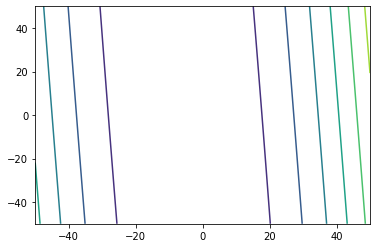

In [33]:
def func(a, b):
    z = np.array([np.zeros(len(a))] * len(a))
    for i in range(M):
        z += ((a * XM[i][1] + b - YM[i])**2 / M)
    return z

def drawLevels():
    a = np.arange(-maxValue * 10, maxValue * 10, 0.05)
    # print(a)
    b = np.arange(-maxValue * 10, maxValue * 10, 0.05)
    a, b = np.meshgrid(a, b)
    z = func(a, b)
    # print(z)
    plt.contour(a, b, z, cmap='viridis')

drawLevels()

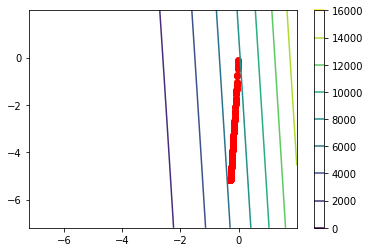


7483.90019906074 7.8915887830053
batch:                    1
actual coefficients:      [-5. -5.]
calculated coefficients:  [-0.29099174 -5.19472634]
number of iterations:     282
number of calculations:   566
execution time:           2520.5600261688232 ms
peak memory: 415.28 MiB, increment: 0.01 MiB

3510.226150923519 7.562089044023671
batch:                    15.0
actual coefficients:      [-5. -5.]
calculated coefficients:  [-0.28345093 -5.23394114]
number of iterations:     22
number of calculations:   690
execution time:           521.4571952819824 ms
peak memory: 299.43 MiB, increment: 3.94 MiB

1445.8051935596295 3.3630421999900704
batch:                    30
actual coefficients:      [-5. -5.]
calculated coefficients:  [-2.80661104 -5.10191537]
number of iterations:     1616
number of calculations:   97020
execution time:           19854.686975479126 ms
peak memory: 299.69 MiB, increment: 4.64 MiB


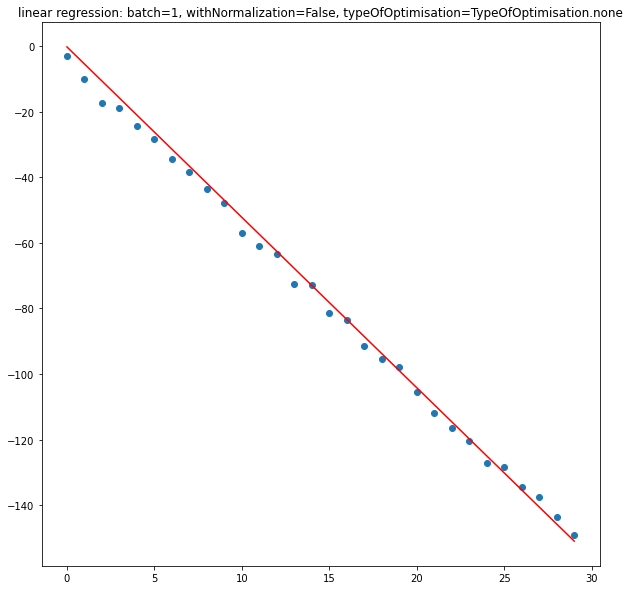

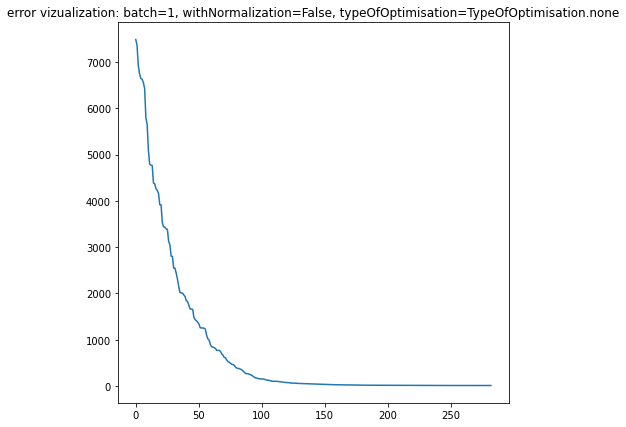

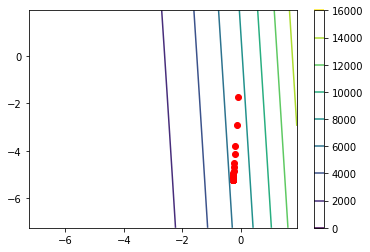

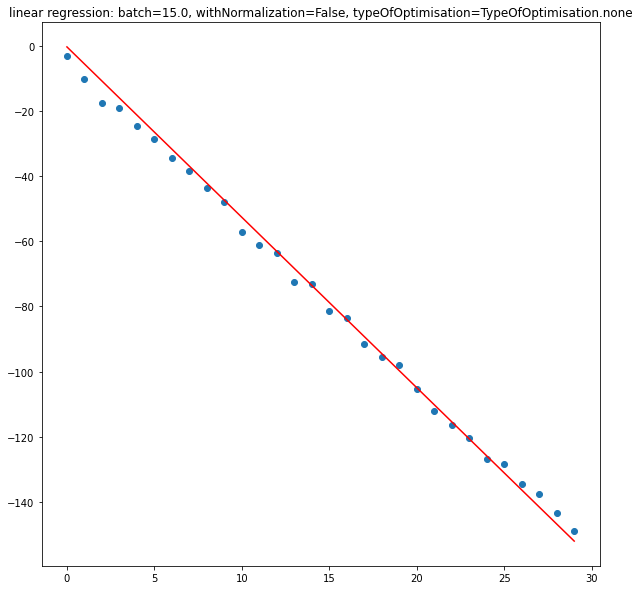

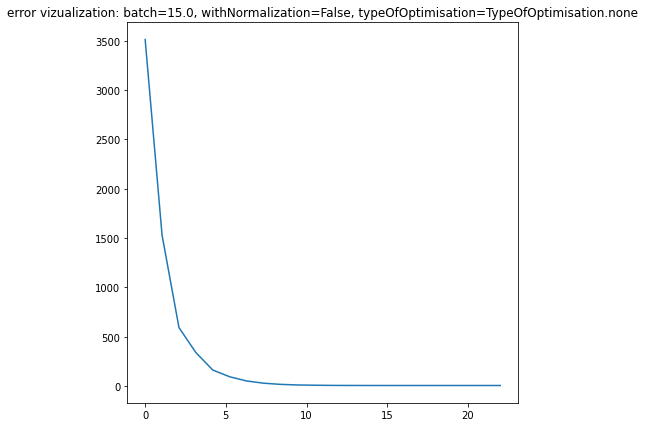

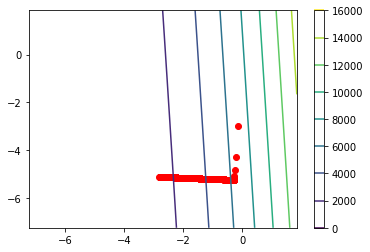

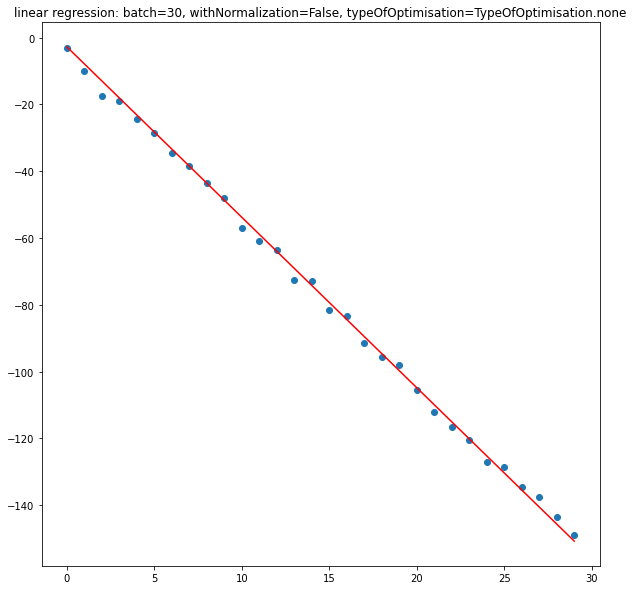

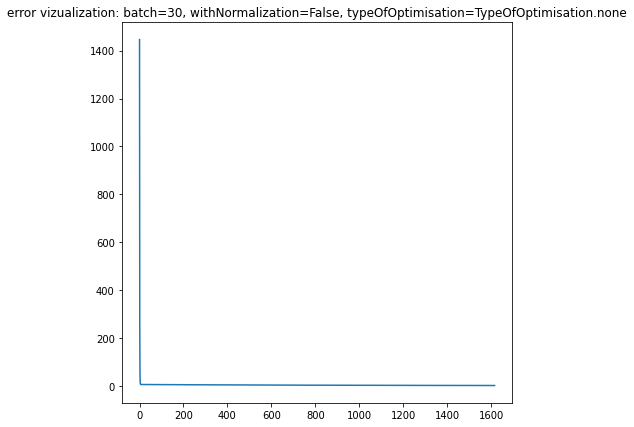

In [34]:
def mean_error(Y_act, Y_reg):
    return np.sum((Y_act - Y_reg)**2) / M


def stopping_criteria(previous, current, eps):
    return abs(previous - current) < eps


def gradient(nums, XM, YR, YM):
    global calculations
    grad = []
    for i in range(N + 1):
        xi = 0
        for k in range(len(nums)):
            xi += XM[nums[k]][i] * (YR[nums[k]] - YM[nums[k]])
            calculations = calculations + 1
            if xi > 1e25:
                return np.array([0] * (N + 1), dtype='float64')
        xi *= 2
        xi /= M
        grad.append(xi)
    return np.array(grad)

def gradient_descent(batch, XM, YM, YR, B_reg, lr, eps, type_of_optimisation, with_normalization):
    # a = [0] * 100000000
    previous_error = 0
    grad = np.array([0] * (N + 1), dtype='float64')
    previous_gradient = np.array([0] * (N + 1), dtype='float64')
    m_adam = np.array([0] * (N + 1), dtype='float64')
    v_adam = np.array([0] * (N + 1), dtype='float64')
    errors = []
    iterations = 0
    Bs = []

    min_B = 1e9
    max_B = -1e9
    min_A = 1e9
    max_A = -1e9

    global calculations
    while True:
        nums = set()
        while len(nums) != batch:
            x = random.randint(0, M - 1)
            if x not in nums:
                nums.add(x)
        nums = np.array(list(nums))

        # :NOTE: optimisations
        if type_of_optimisation == TypeOfOptimisation.none:
            grad = gradient(nums, XM, YR, YM)
        elif type_of_optimisation == TypeOfOptimisation.momentum:
            grad = gradient(nums, XM, YR, YM)
            grad += gamma * previous_gradient
            calculations = calculations + 1
        elif type_of_optimisation == TypeOfOptimisation.Nesterov:
            B_prev = B_reg - lr * previous_gradient
            YR_new = [0] * M
            for i in range(M):
                YR_new[i] = y_regression(B_prev, XM[i])
            grad = gradient(nums, XM, np.array(YR_new), YM)
            grad += gamma * previous_gradient
            calculations = calculations + 2 + M
        elif type_of_optimisation == TypeOfOptimisation.AdaGrad:
            grad = gradient(nums, XM, YR, YM)
            new_grad = previous_gradient + np.square(grad)
            new_grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
            grad = new_grad
            calculations = calculations + 2
        elif type_of_optimisation == TypeOfOptimisation.RMSProp:
            grad = gradient(nums, XM, YR, YM)
            new_grad = gamma * previous_gradient + (1 - gamma) * np.square(grad)
            new_grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
            grad = new_grad
            calculations = calculations + 2
        elif type_of_optimisation == TypeOfOptimisation.Adam:
            grad = gradient(nums, XM, YR, YM)
            m_adam = beta_1 * m_adam + (1 - beta_1) * grad
            v_adam = beta_2 * v_adam + (1 - beta_2) * np.square(grad)
            m = m_adam / (1 - beta_1)
            v = v_adam / (1 - beta_2)
            grad = m / np.sqrt(abs(v + eps))
            calculations = calculations + 5

        B_reg -= lr * grad
        plt.scatter(B_reg[0], B_reg[1], color='red')

        max_B = max(max_B, B_reg[1])
        min_B = min(min_B, B_reg[1])
        max_A = max(max_A, B_reg[0])
        min_A = min(min_A, B_reg[0])

        for i in range(M):
            YR[i] = y_regression(B_reg, XM[i])
        if stopping_criteria(previous_error, mean_error(YM, YR), eps):
            break
        previous_error = mean_error(YM, YR)
        previous_gradient = grad
        errors.append(previous_error)
        iterations += 1
    # print(min_A, min_B)
    minn = min(min_A, min_B)
    minn -= 2
    maxx = max(max_A, max_B)
    maxx += 2
    a = np.linspace(minn, maxx, 100)
    b = np.linspace(minn, maxx, 100)
    a, b = np.meshgrid(a, b)
    z = func(a, b)
    ctr = plt.contour(a, b, z, cmap='viridis')
    plt.colorbar(ctr)

    plt.show()
    return B_reg, errors, YR, iterations


def draw_graph(XM, YM, YF, batch, withNormalization, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    X = XM.T[1]
    plt.scatter(X, YM)
    plt.plot(X, YF, color='red')
    title = 'linear regression: batch=' + str(batch) + \
            ', withNormalization=' + str(withNormalization) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()


def draw_errors_graphic(E, iterations, batch, withNormalization, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    i = np.linspace(0, iterations, iterations)
    plt.plot(i, E)
    title = 'error vizualization: batch=' + str(batch) + \
            ', withNormalization=' + str(withNormalization) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()

%memit runSGD(1, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)
%memit runSGD(M / 2, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)
%memit runSGD(M, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)

# Задание 2

/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


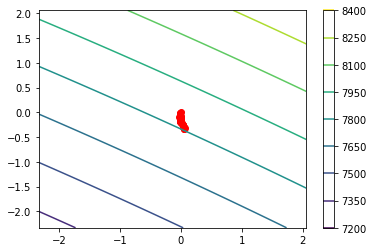


0.9987811182128702 0.4477975970852128
batch:                    1
actual coefficients:      [nan nan]
calculated coefficients:  [ 0.05252785 -0.33320846]
number of iterations:     57
number of calculations:   116
execution time:           747.2331523895264 ms
peak memory: 298.26 MiB, increment: 3.10 MiB

0.9790205229997839 0.001444363025760722
batch:                    15.0
actual coefficients:      [nan nan]
calculated coefficients:  [-0.00145071 -0.98673374]
number of iterations:     437
number of calculations:   13140
execution time:           5069.177865982056 ms
peak memory: 299.63 MiB, increment: 4.52 MiB

0.9604507784480404 0.001307513412050698
batch:                    30
actual coefficients:      [nan nan]
calculated coefficients:  [-5.58164626e-17 -9.94436225e-01]
number of iterations:     262
number of calculations:   15780
execution time:           3148.386001586914 ms
peak memory: 298.20 MiB, increment: 3.09 MiB


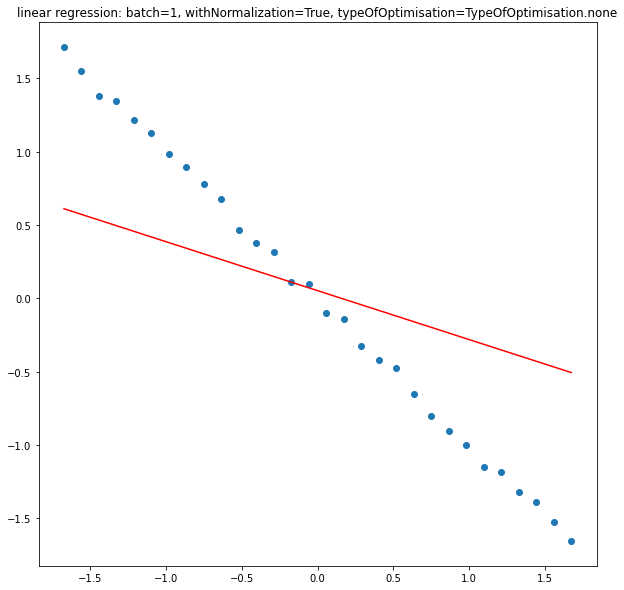

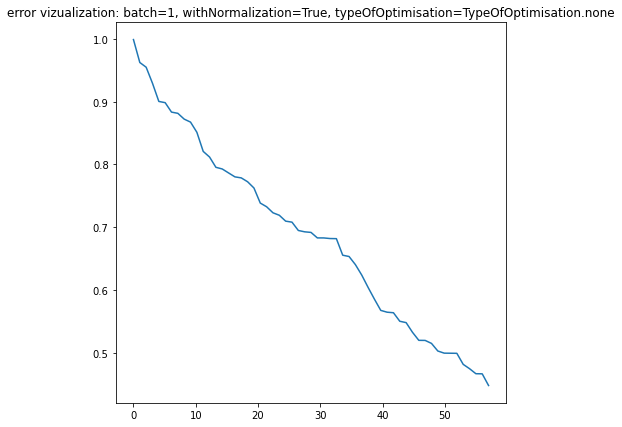

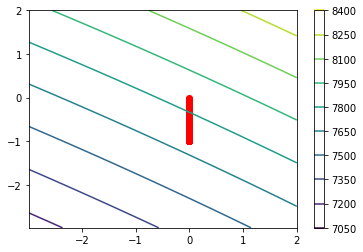

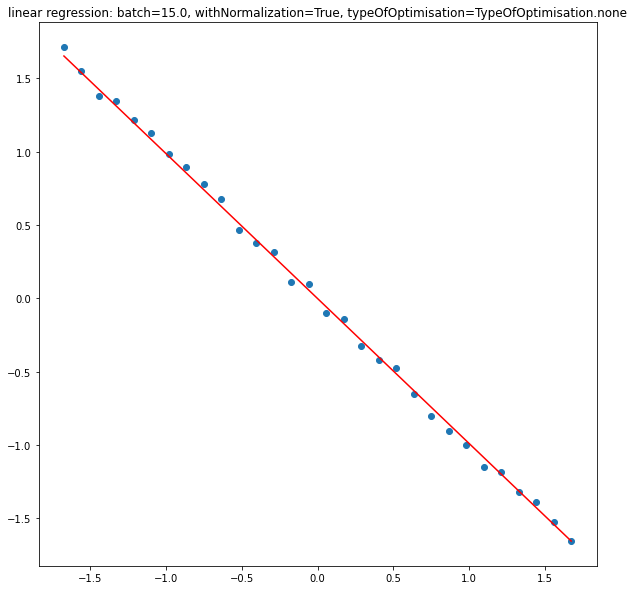

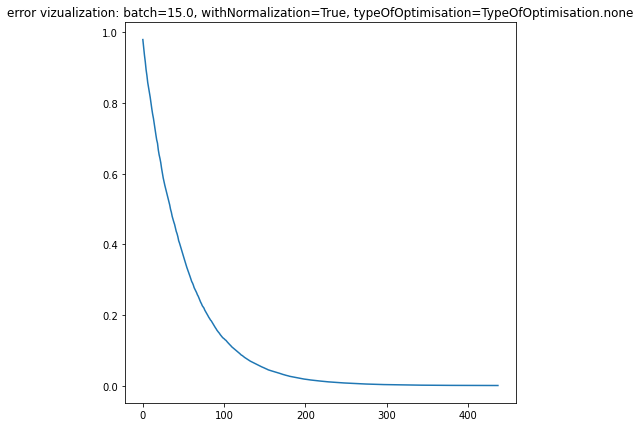

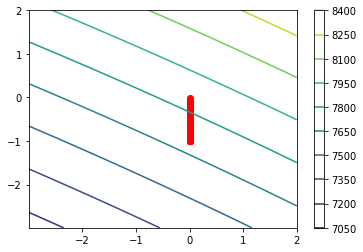

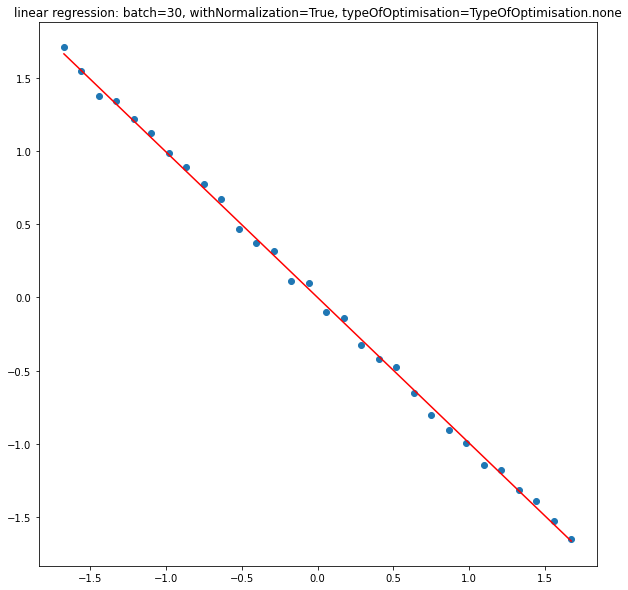

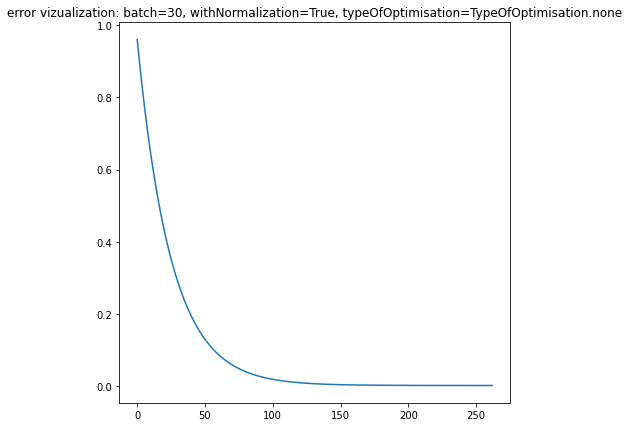

In [35]:
def ZNormalization(XM):
    X = XM.T
    for i in range(1, N + 1):
        X[i] = (X[i] - np.mean(X[i])) / np.std(X[i])
    return X.T


# print(XM)
%memit runSGD(1, TypeOfOptimisation.none, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.none, withNormalization=True, lr=1e-2, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.none, withNormalization=True, lr=1e-2, eps=1e-6)

# Задание 3

### Метод моментов

Смысл заключается в том, что мы на каждом шаге прибавляем к значению градиента
предыдущий градиент умноженный на константу. Это позволяет градиентному спуску не застревать
в локальных минимумах.

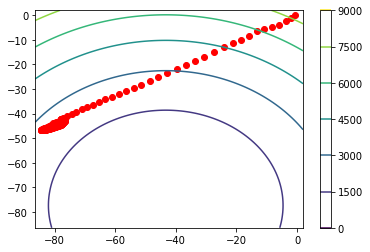


7765.387254331974 2.414281920117102
batch:                    1
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.35058467 -43.30334423]
number of iterations:     260
number of calculations:   783
execution time:           2780.057191848755 ms
peak memory: 301.19 MiB, increment: 6.08 MiB

6792.074024743542 2.464660654770606
batch:                    15.0
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.08632859 -43.1923971 ]
number of iterations:     351
number of calculations:   10912
execution time:           4157.865047454834 ms
peak memory: 301.81 MiB, increment: 6.62 MiB

5026.014090915833 2.4096070593647965
batch:                    30
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.27602875 -43.31643807]
number of iterations:     146
number of calculations:   8967
execution time:           1768.2318687438965 ms
peak memory: 299.85 MiB, increment: 4.62 MiB

0.996770829052918 0.0017436539392383453
batch:                    1
a

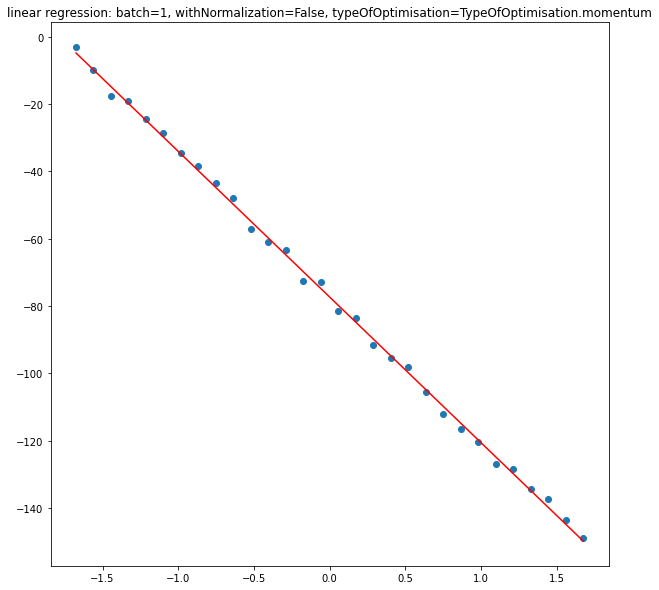

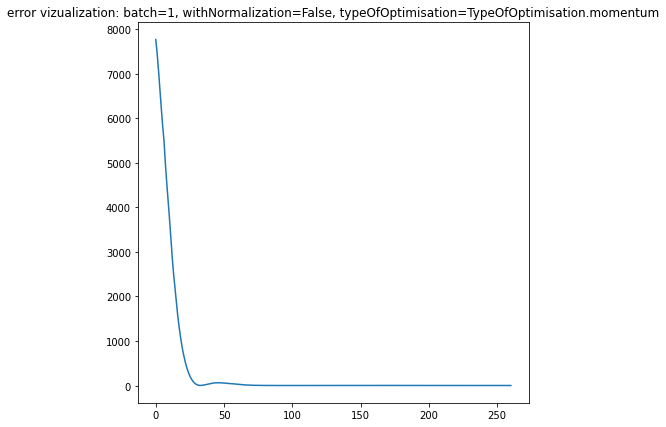

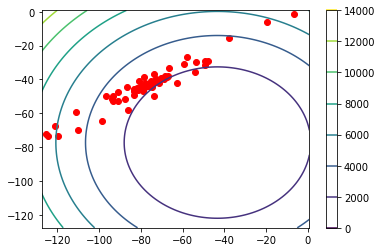

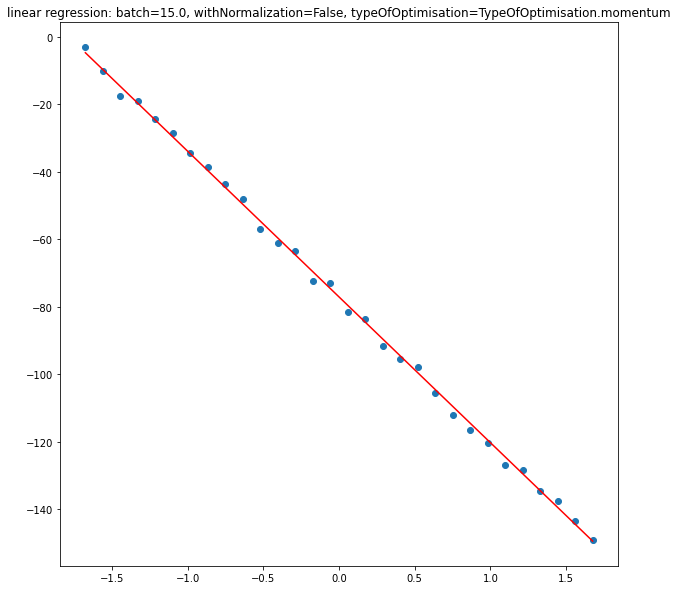

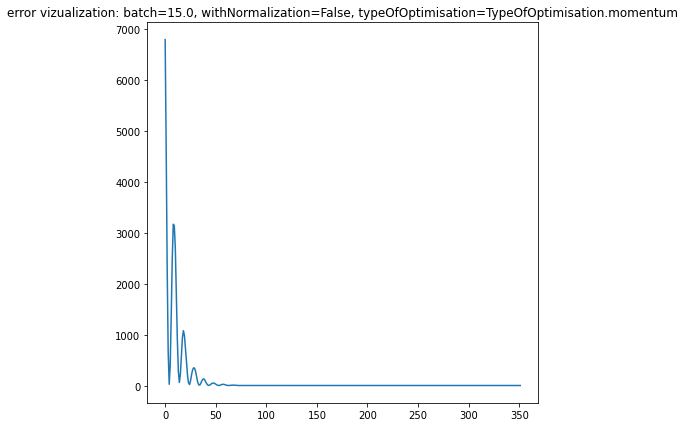

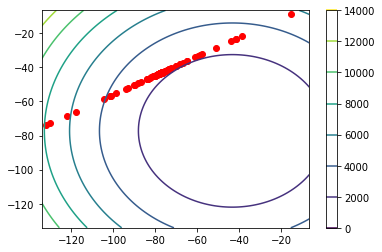

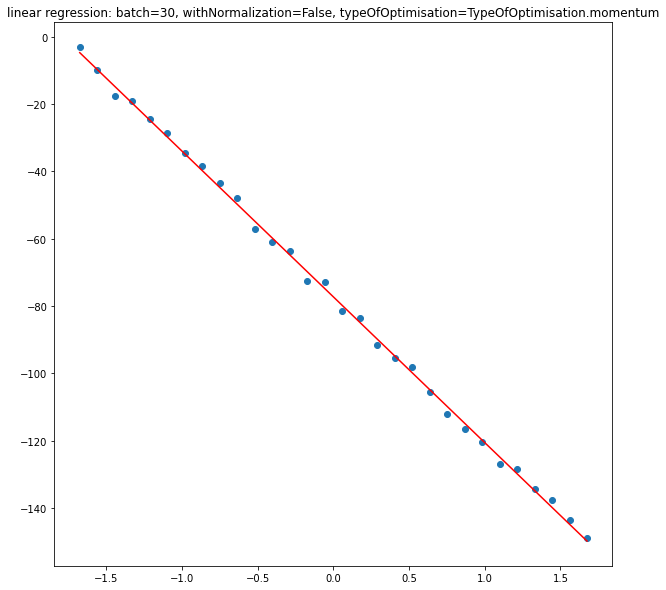

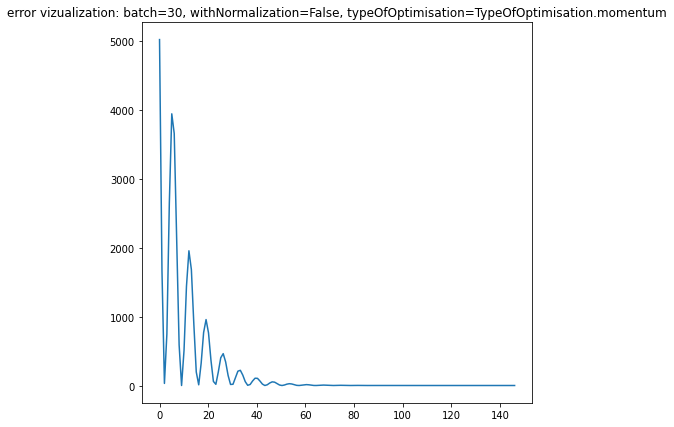

/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


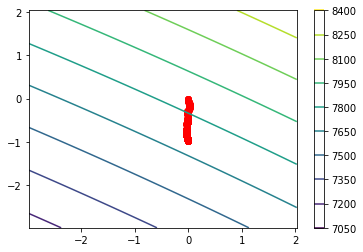

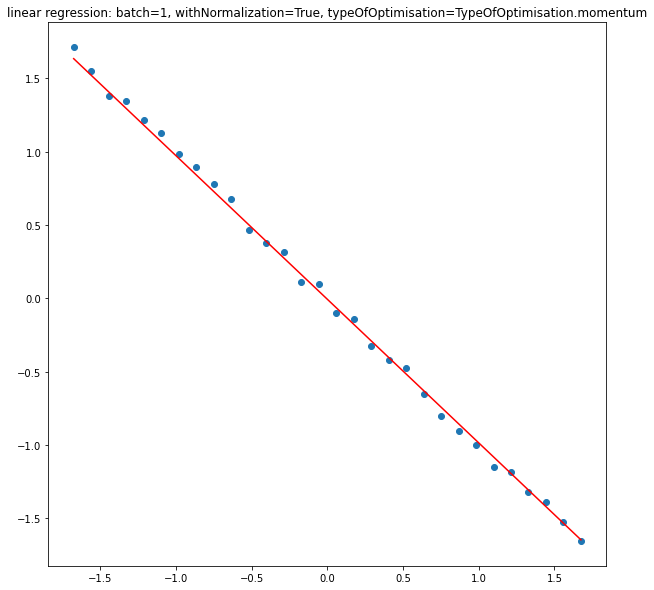

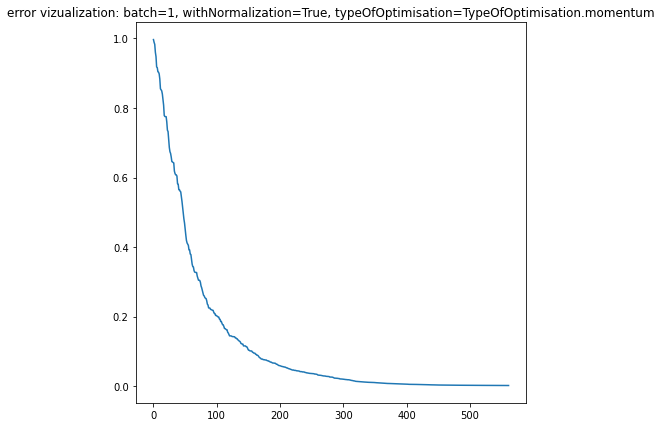

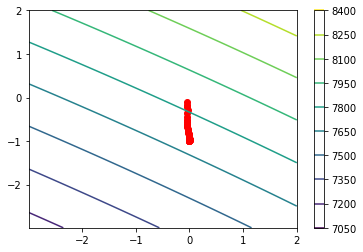

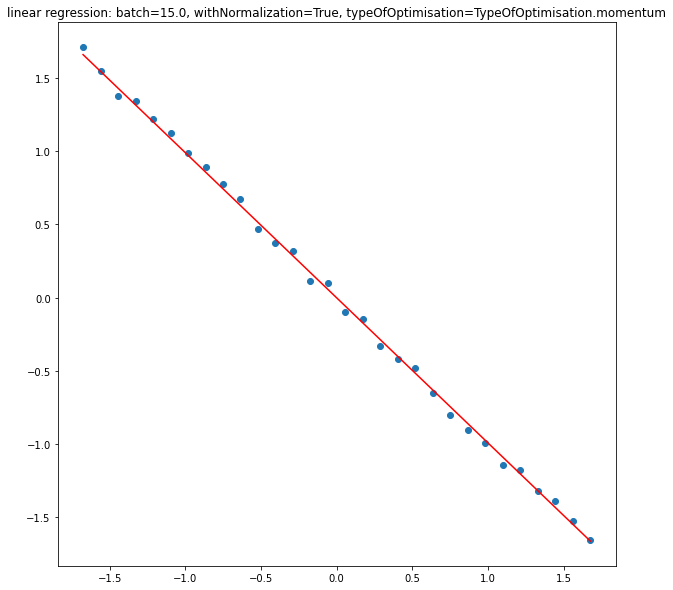

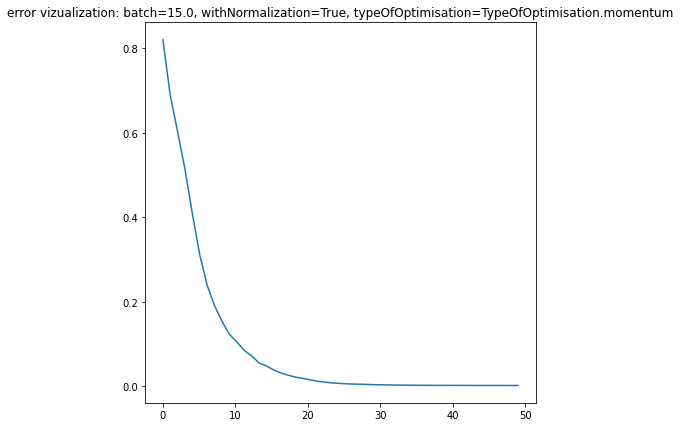

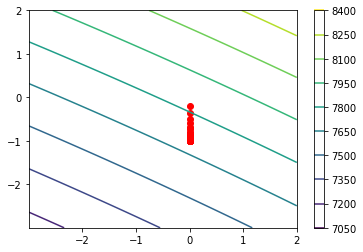

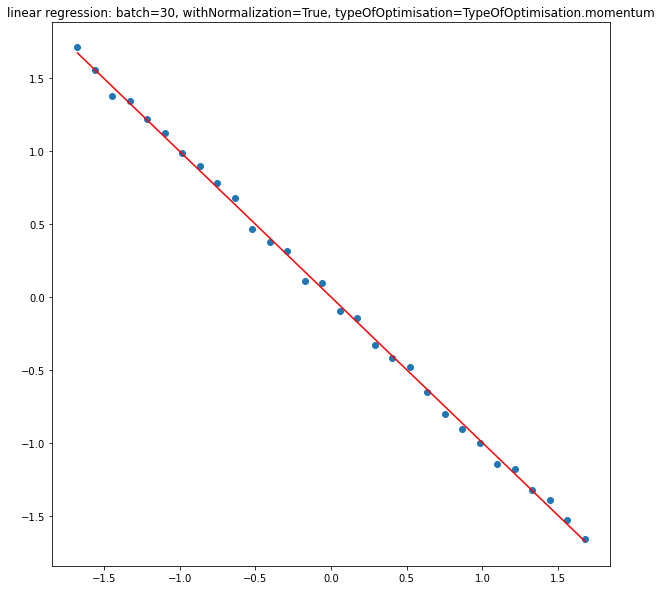

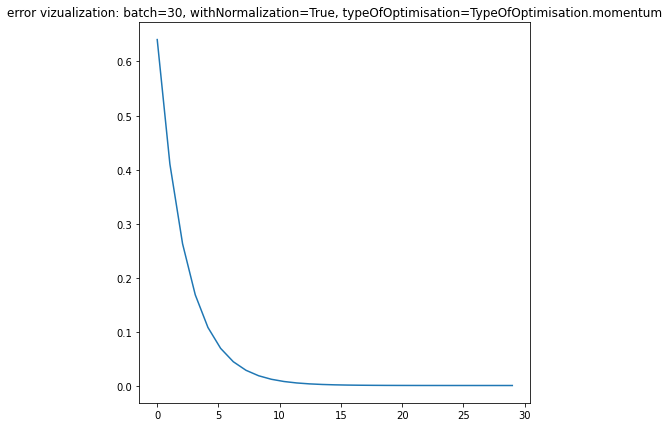

In [36]:
gamma = 0.9

%memit runSGD(1, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M / 2, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(1, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-6)

### Метод Нестерова

Здесь используется тот же смысл, как и в методе моментов, только градиент мы считаем не от текущей точки,
а от следующей (как бы заглядывая вперед). Дает более быструю сходимость, чем метод моментов.

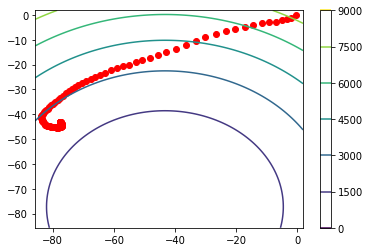


7742.643875862069 2.5698992346435583
batch:                    1
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.54147319 -43.01436913]
number of iterations:     118
number of calculations:   4046
execution time:           1623.671054840088 ms
peak memory: 299.75 MiB, increment: 4.49 MiB

6401.386729749104 2.4139957669019916
batch:                    15.0
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.28286712 -43.38796529]
number of iterations:     162
number of calculations:   10106
execution time:           1767.772912979126 ms
peak memory: 299.80 MiB, increment: 4.55 MiB

5026.014090915833 2.4128974593042503
batch:                    30
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.23191877 -43.29171258]
number of iterations:     40
number of calculations:   3772
execution time:           614.2442226409912 ms
peak memory: 299.76 MiB, increment: 4.50 MiB

0.9943086606667947 0.0015305639784468558
batch:                    1

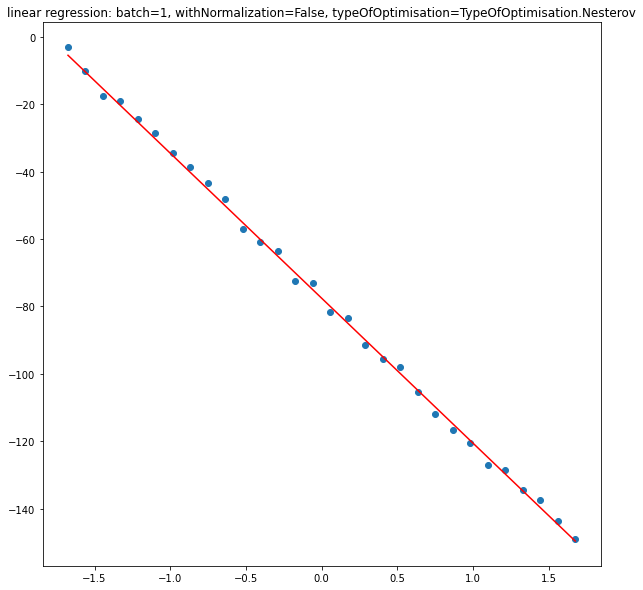

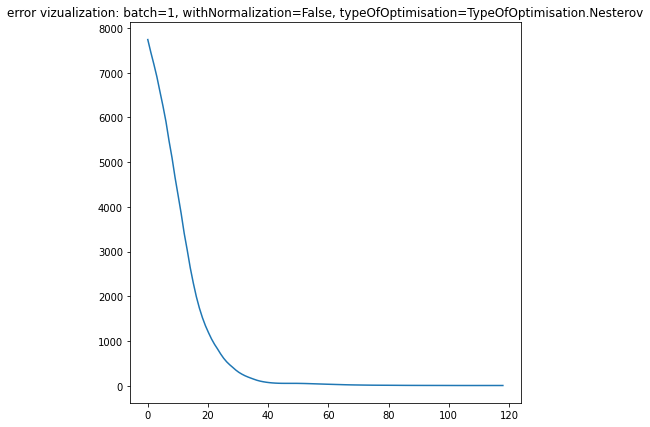

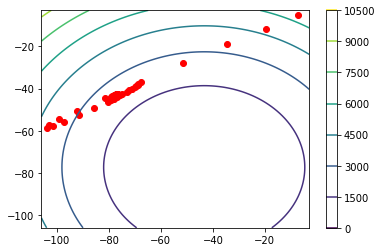

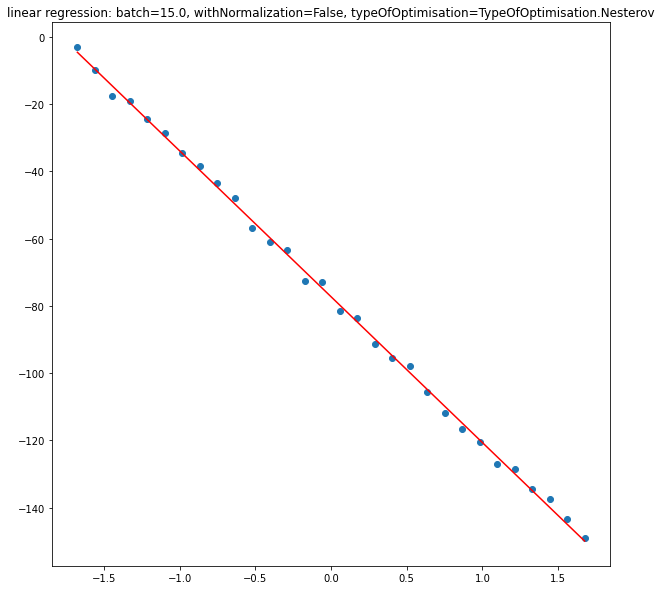

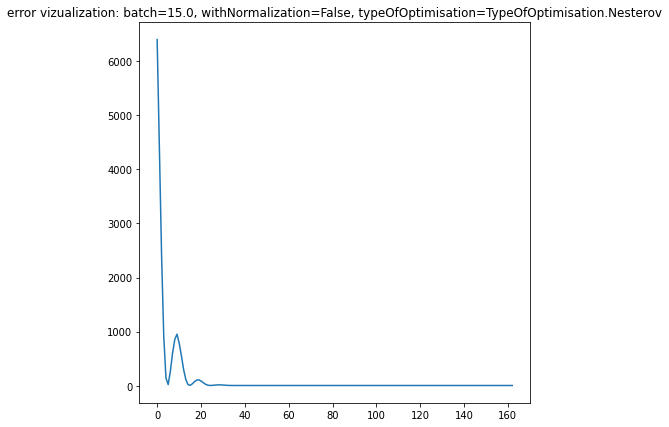

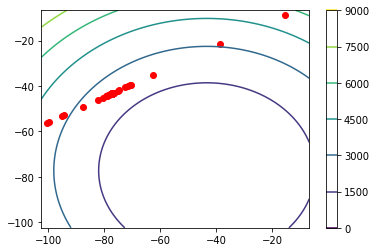

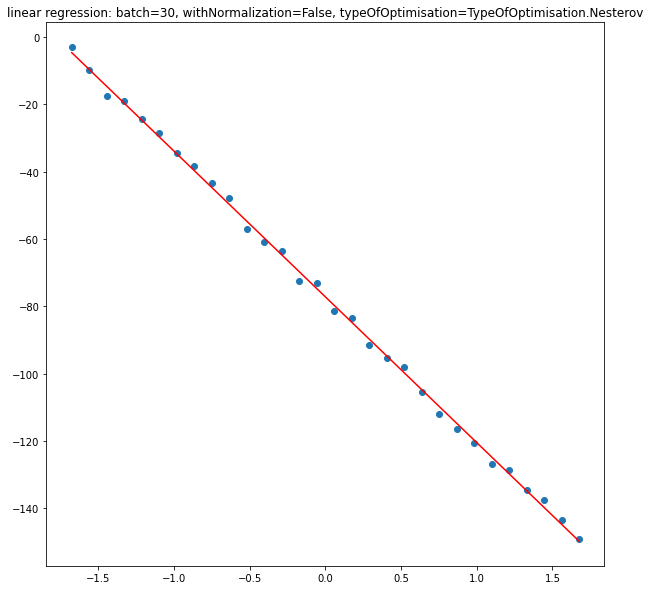

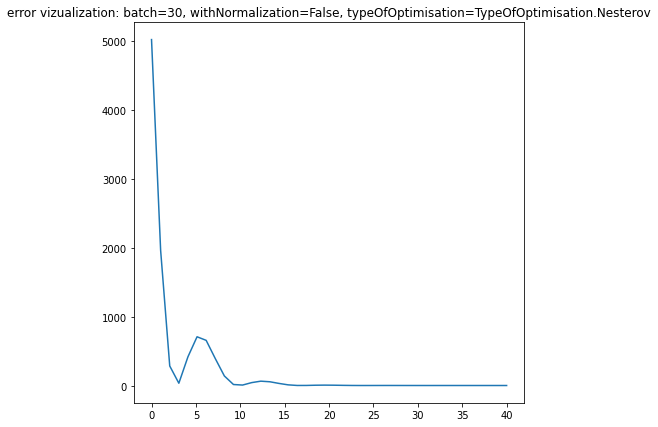

/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


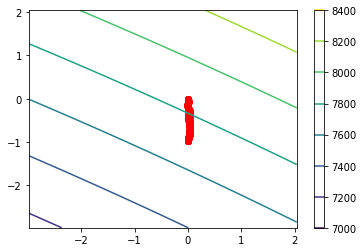

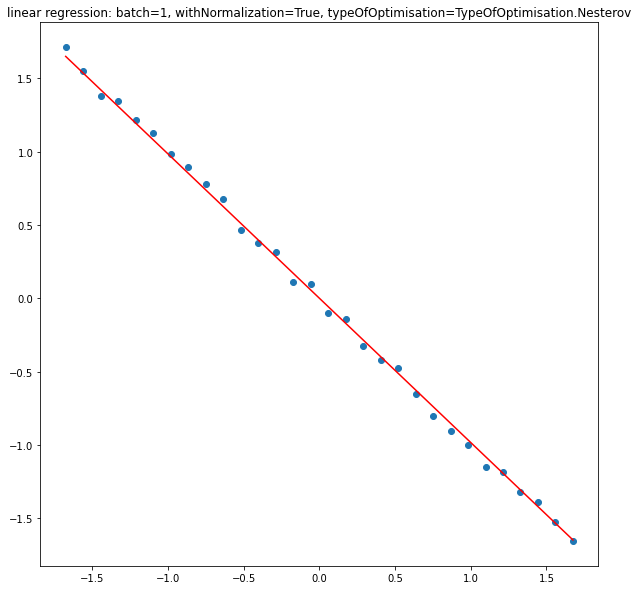

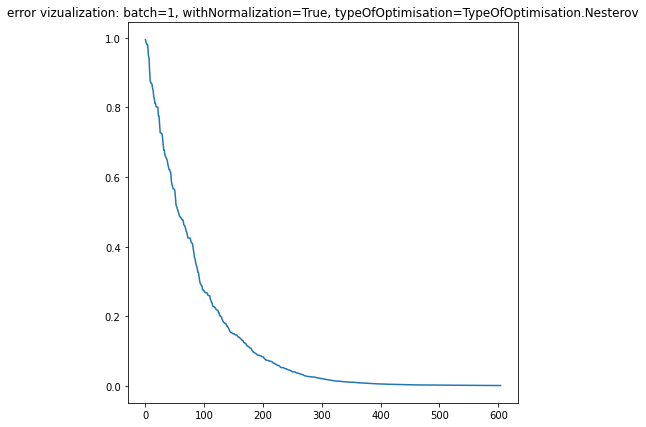

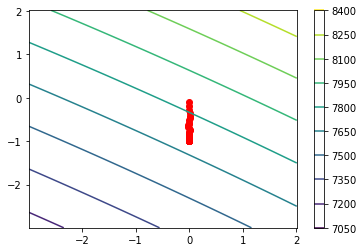

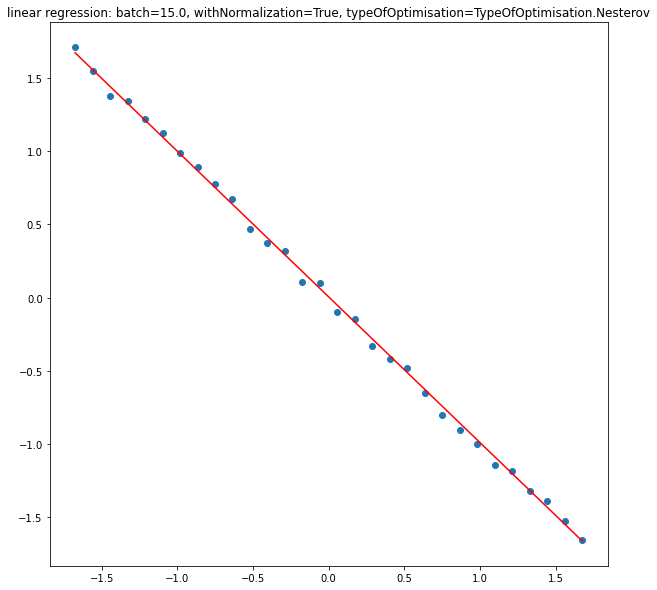

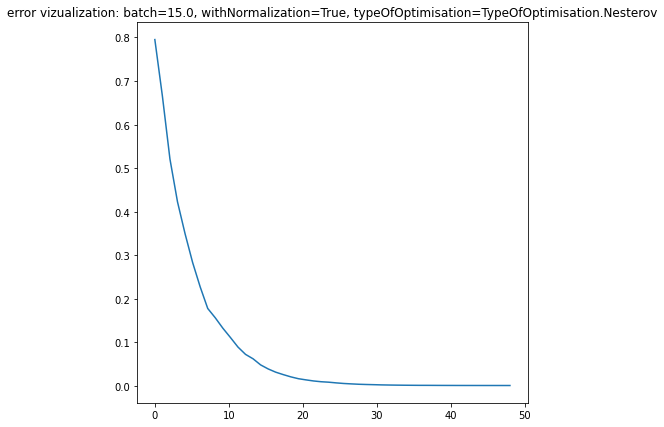

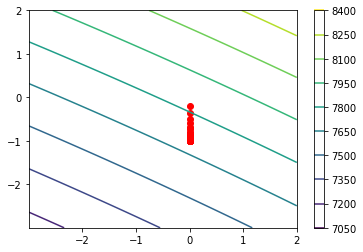

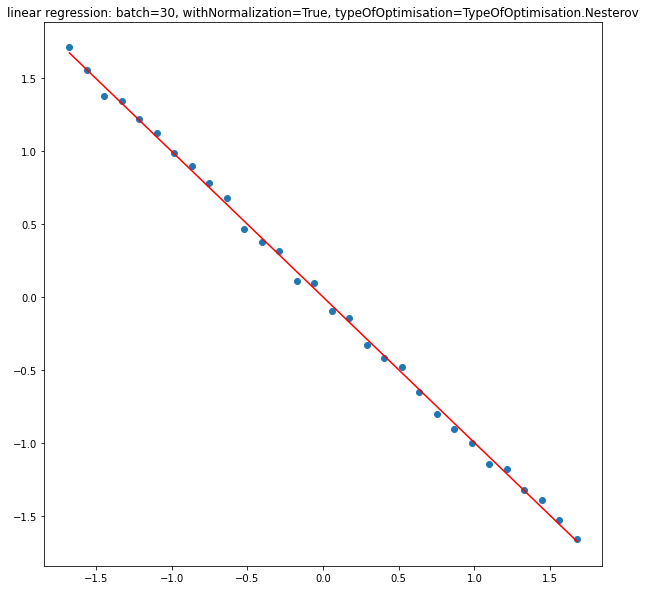

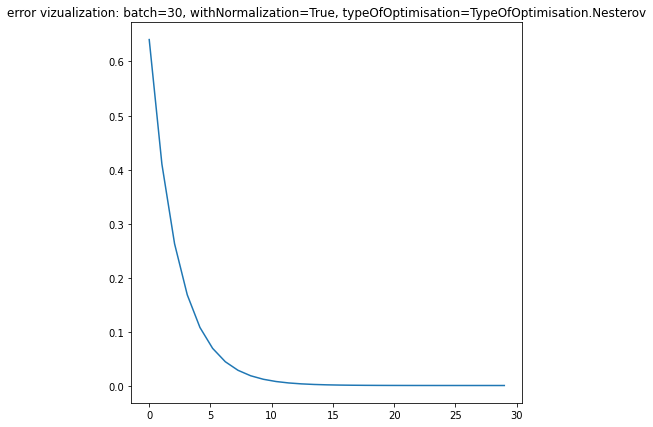

In [37]:
%memit runSGD(1, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M / 2, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(1, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-6)

### AdaGrad

Некоторые параметры могут быстрее достигать своего оптимума. То есть те параметры, которые близки к оптимуму,
нужно менять с меньшим шагом, а другие с большим.

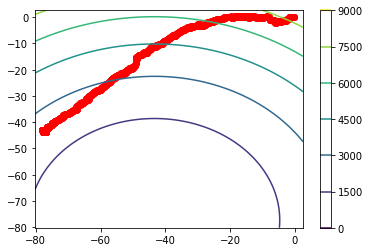


7827.690893671342 2.780532022100512
batch:                    1
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.86239572 -43.50949453]
number of iterations:     1881
number of calculations:   7528
execution time:           20677.727222442627 ms
peak memory: 300.06 MiB, increment: 4.81 MiB

7827.69089350102 2.4112764318087008
batch:                    15.0
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.2802726 -43.3623797]
number of iterations:     2543
number of calculations:   81408
execution time:           36158.06794166565 ms
peak memory: 300.87 MiB, increment: 5.43 MiB

7827.690893491285 2.4095135846860276
batch:                    30
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.28338128 -43.32003286]
number of iterations:     783
number of calculations:   48608
execution time:           9369.618892669678 ms
peak memory: 298.29 MiB, increment: 4.55 MiB

0.9897321801674767 0.0031192511077394883
batch:                    

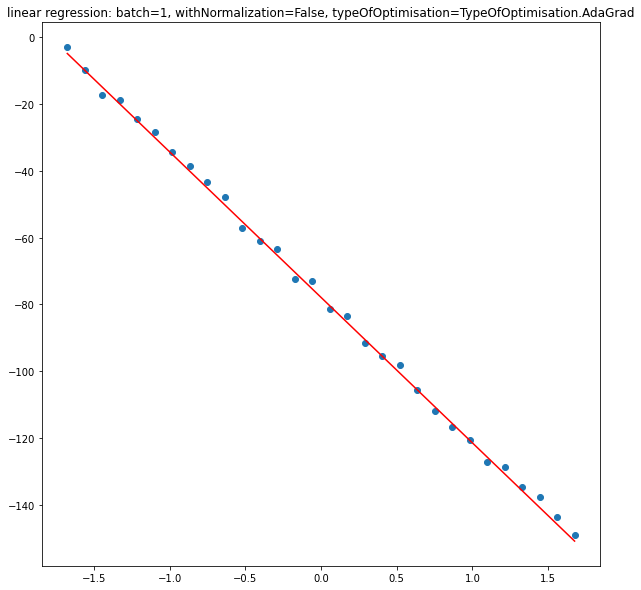

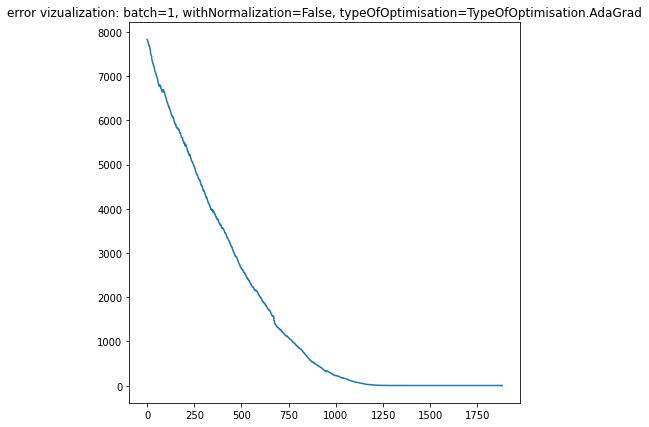

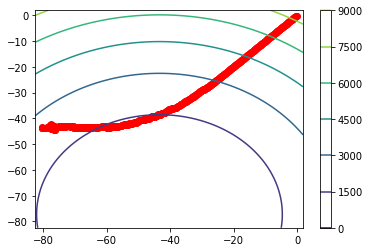

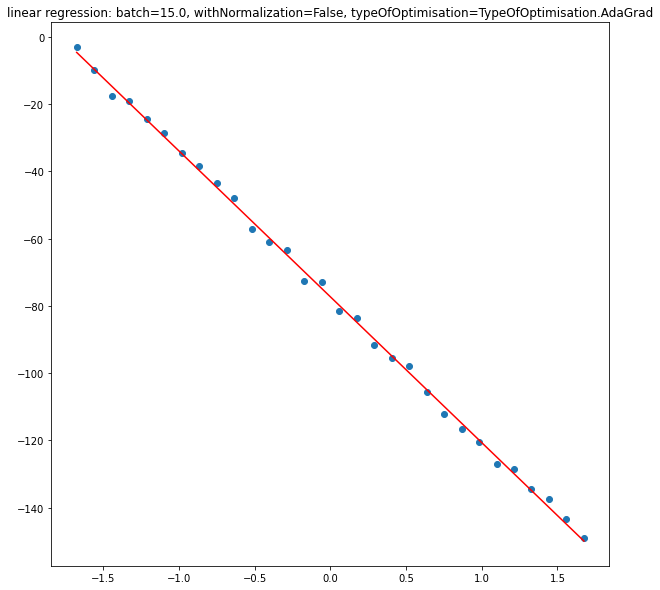

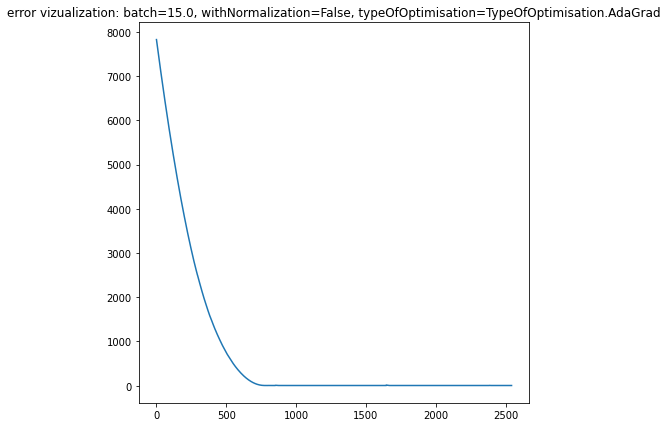

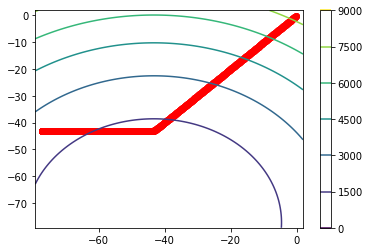

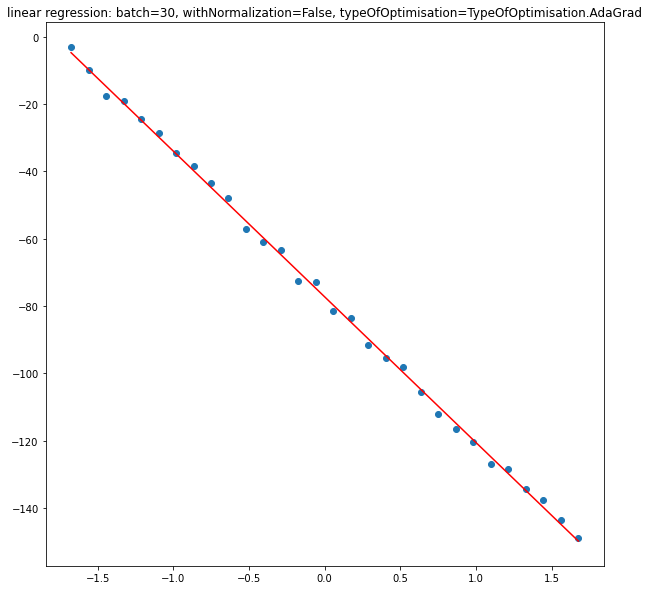

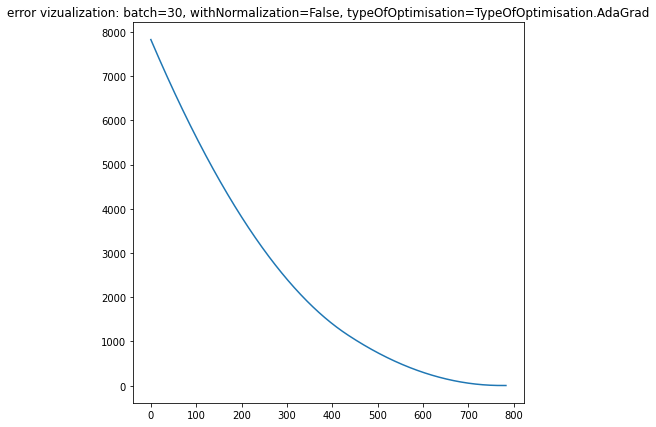

/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


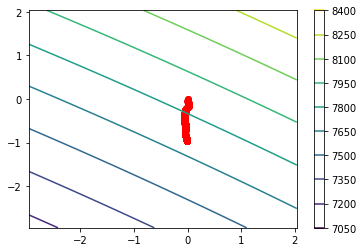

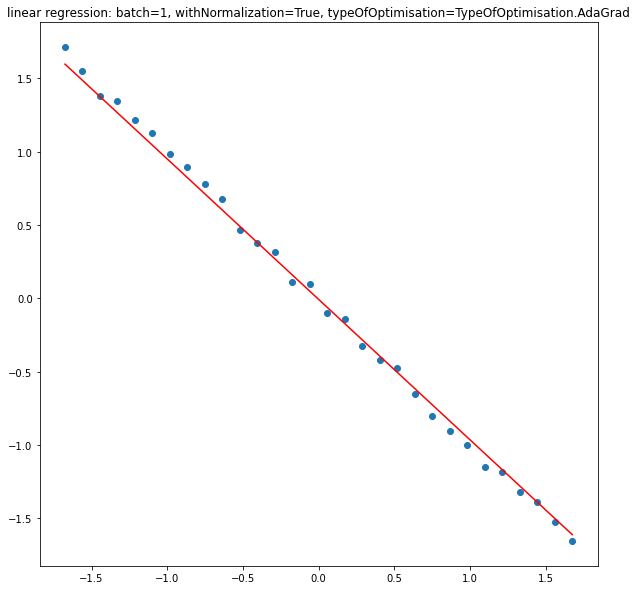

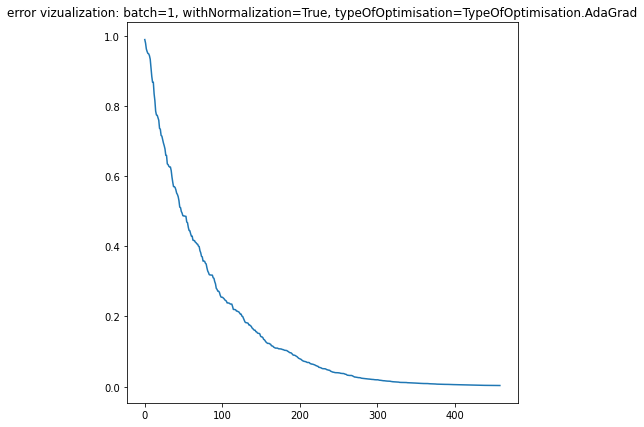

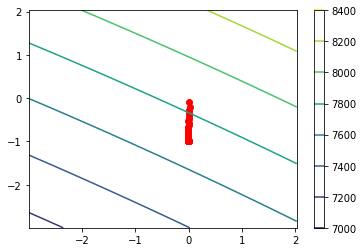

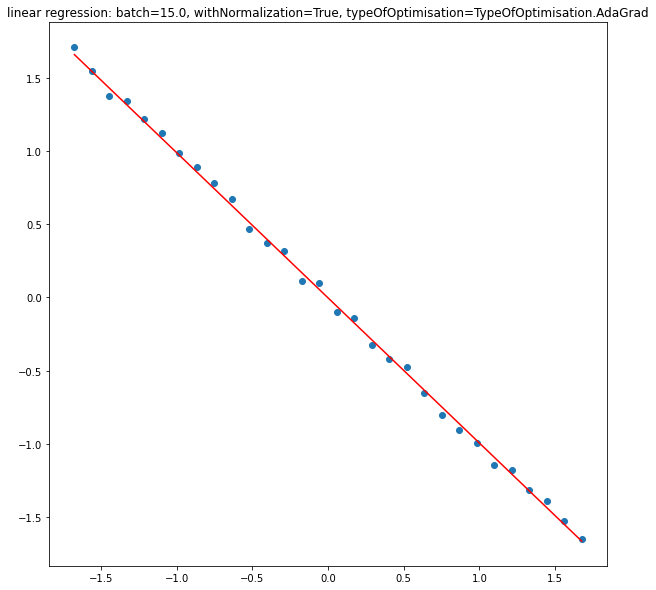

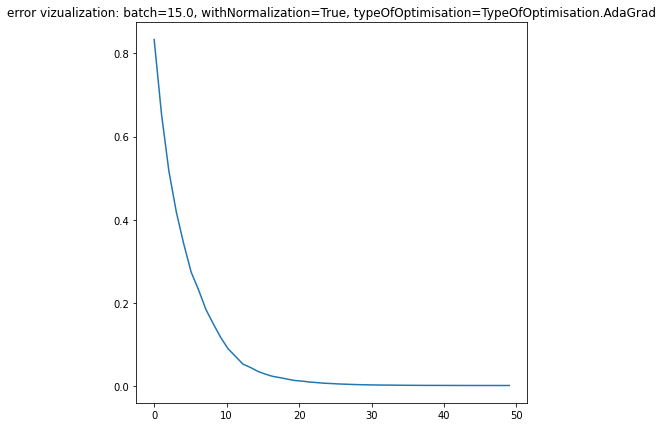

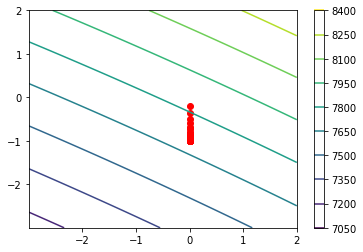

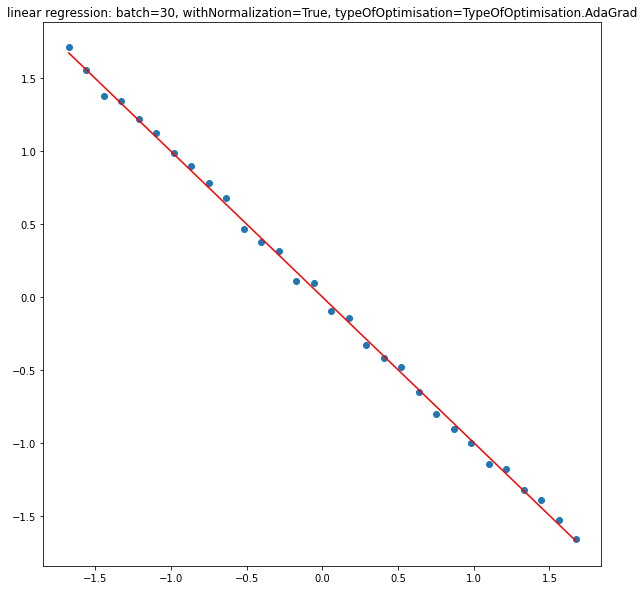

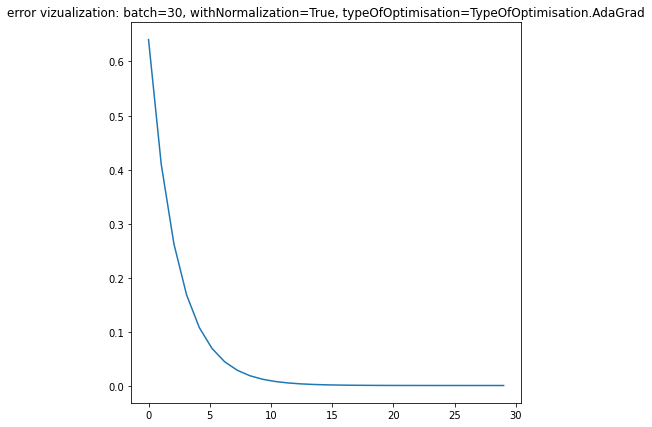

In [38]:
%memit runSGD(1, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-6)
%memit runSGD(M / 2, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-5)
%memit runSGD(M, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-5)
%memit runSGD(1, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-6)

### RMSProp

Идея сохранять не всю историю по квадратам градиеента, а только часть. Использовать дисконтирующий множитель,
чтобы ограничеть действие далеких градиентов, вычесленных давно.

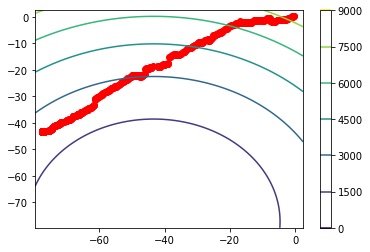


7830.560155470355 2.434631146085472
batch:                    1
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.23378286 -43.47106351]
number of iterations:     988
number of calculations:   3956
execution time:           11142.187118530273 ms
peak memory: 299.58 MiB, increment: 3.07 MiB

7775.715085255494 2.461473037021224
batch:                    15.0
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.34843526 -43.53897838]
number of iterations:     1422
number of calculations:   45536
execution time:           16961.710691452026 ms
peak memory: 301.34 MiB, increment: 4.86 MiB

7775.715084762786 2.4095167373949407
batch:                    30
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.28320842 -43.31997731]
number of iterations:     263
number of calculations:   16368
execution time:           3350.3870964050293 ms
peak memory: 299.66 MiB, increment: 3.00 MiB

0.9999243764392267 0.0013360117464492982
batch:                 

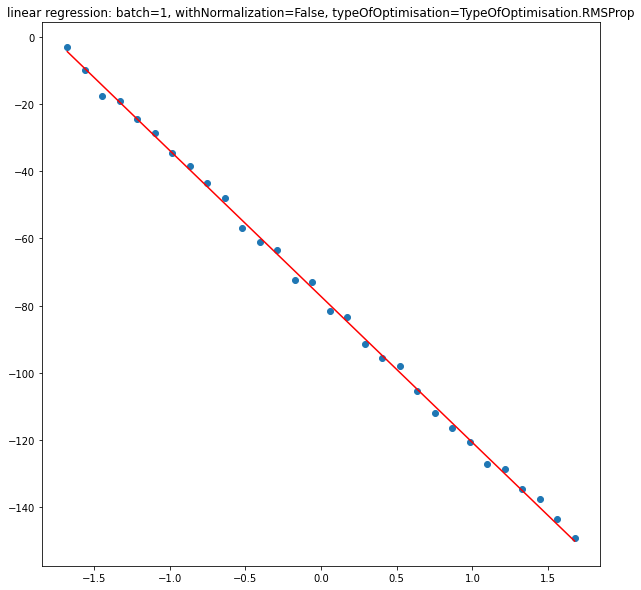

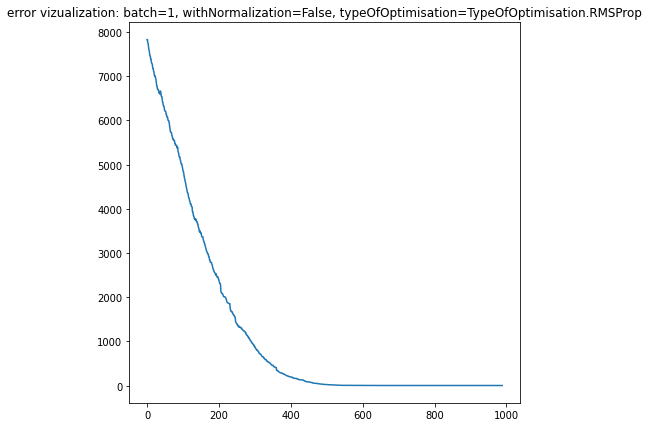

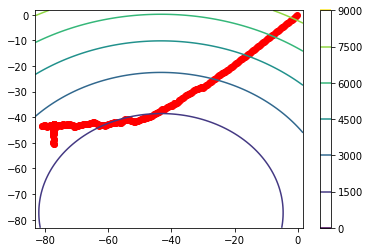

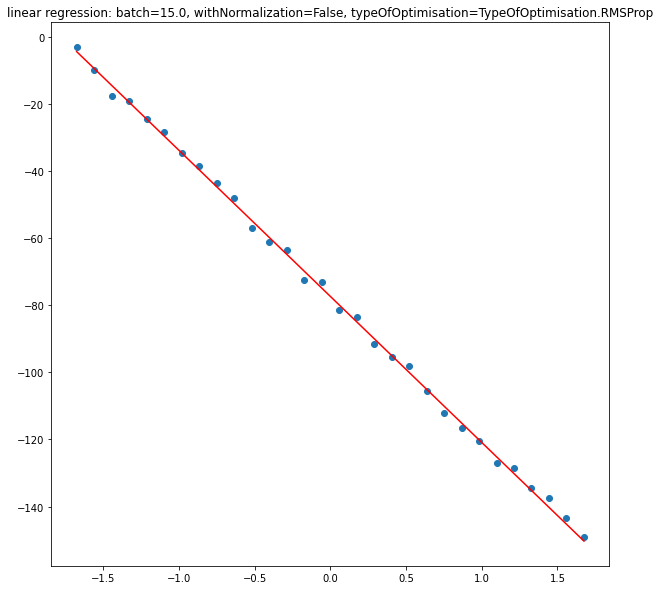

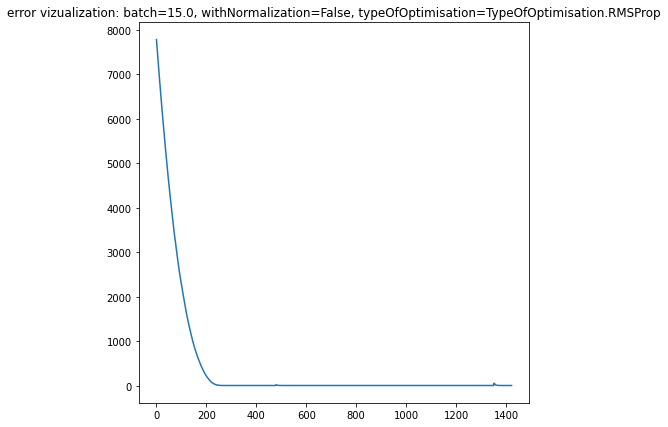

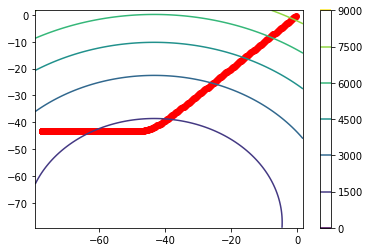

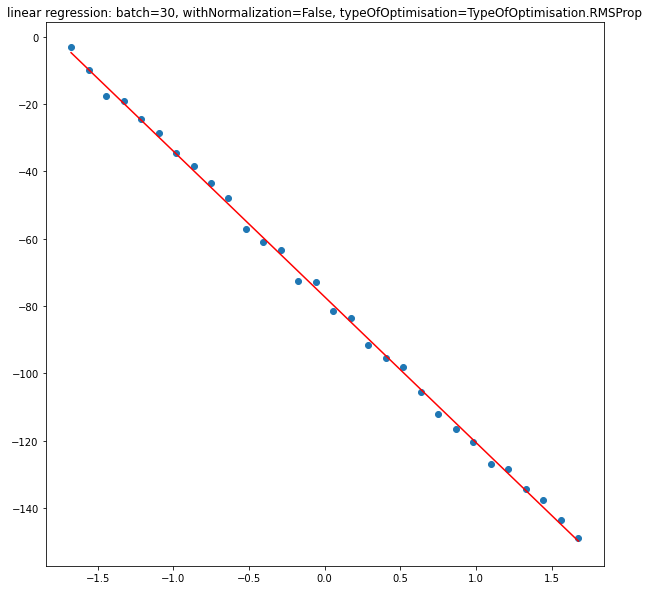

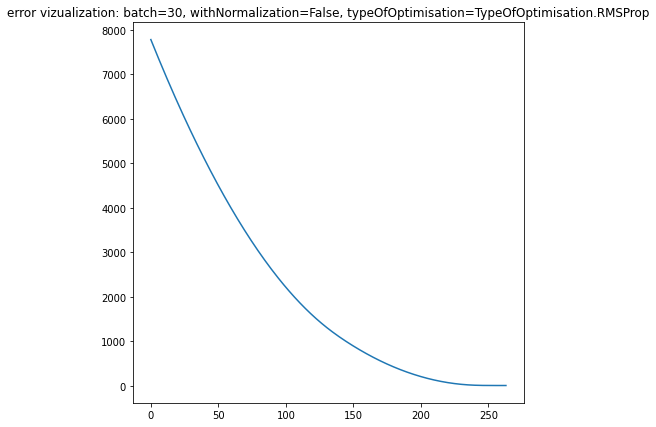

/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


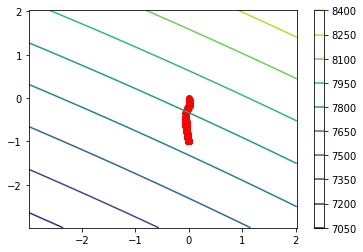

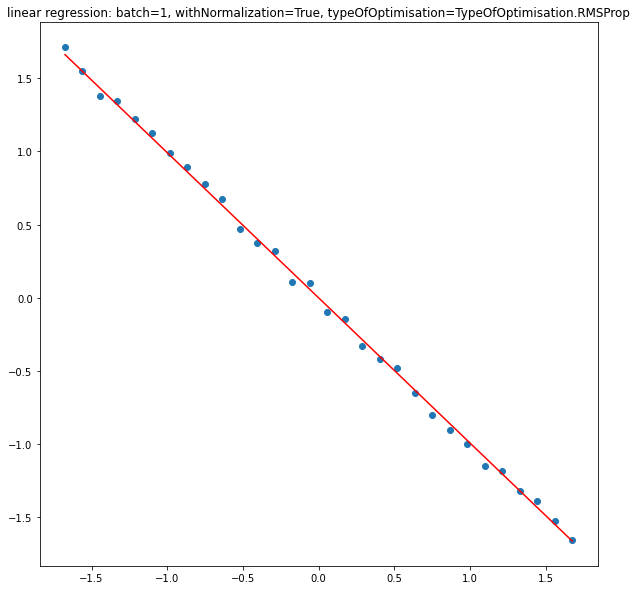

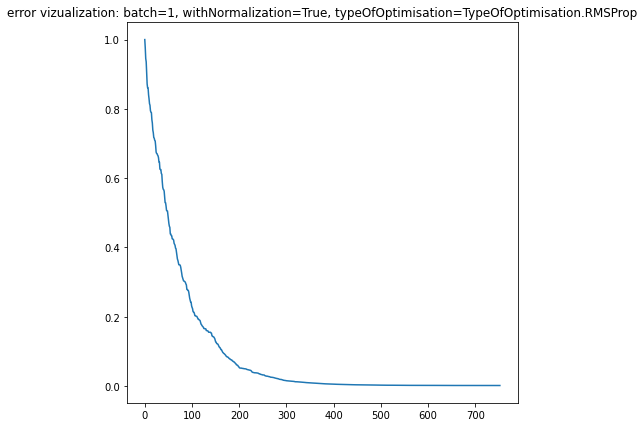

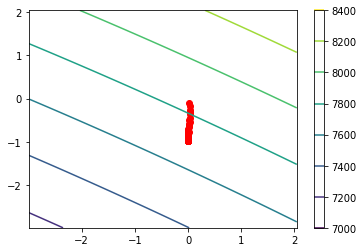

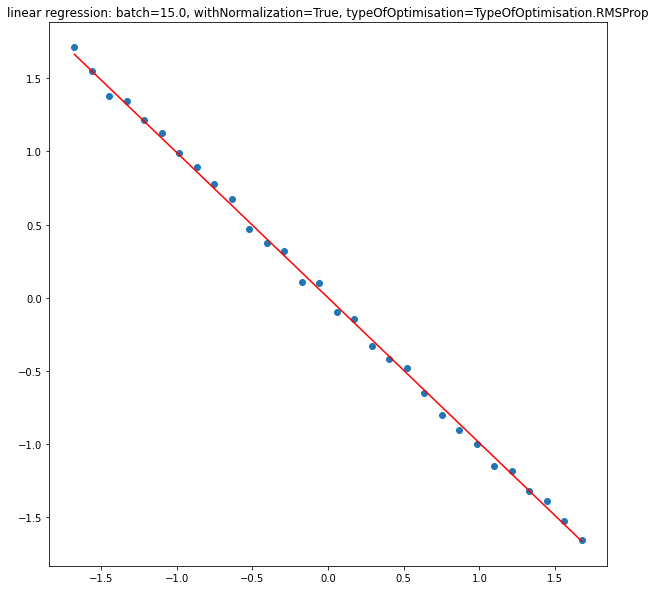

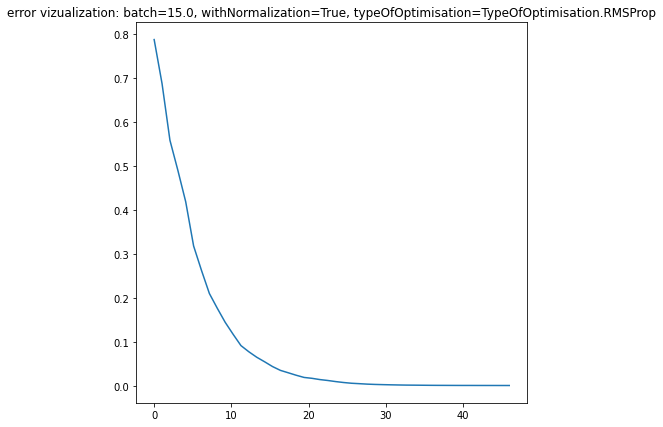

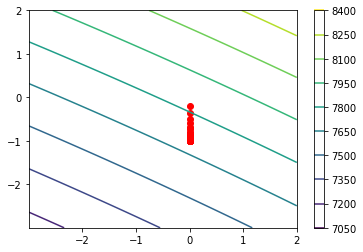

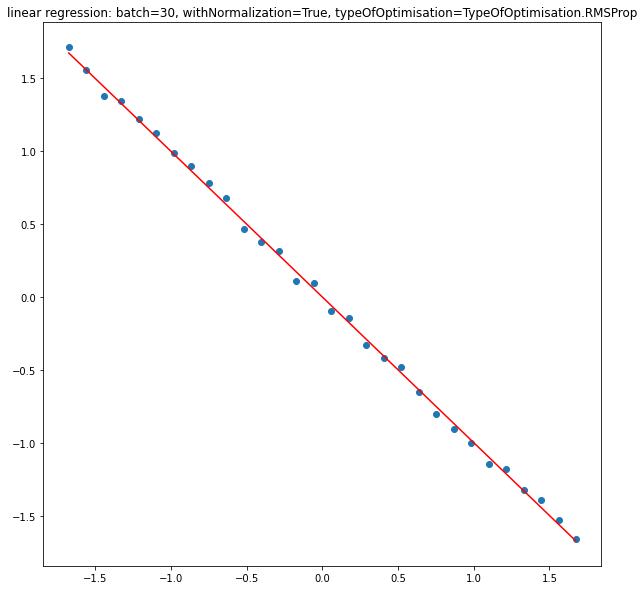

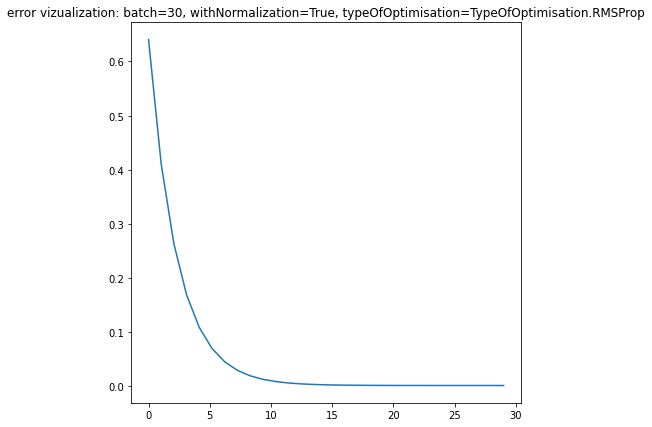

In [39]:
%memit runSGD(1, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-5)
%memit runSGD(M / 2, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-5)
%memit runSGD(M, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-5)
%memit runSGD(1, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-6)


### Adam

Фактически, этот алгоритм является очередной модификацией алгоритма Adagrad, 
использующий сглаженные версии среднего и среднеквадратического градиентов

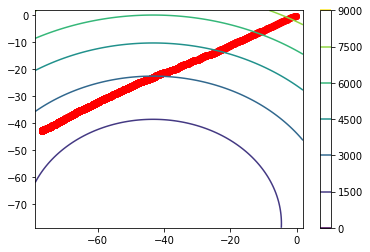


7827.69094902486 2.780903285289651
batch:                    1
actual coefficients:      [-5. -5.]
calculated coefficients:  [-76.89854246 -42.84805354]
number of iterations:     4019
number of calculations:   28140
execution time:           58342.15307235718 ms
peak memory: 315.71 MiB, increment: 19.12 MiB

7827.690893704169 2.4329925330510065
batch:                    15.0
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.13048741 -43.31610627]
number of iterations:     3813
number of calculations:   133490
execution time:           51641.13402366638 ms
peak memory: 311.67 MiB, increment: 12.56 MiB

7827.690893572181 2.4238199215085214
batch:                    30
actual coefficients:      [-5. -5.]
calculated coefficients:  [-77.1641339  -43.32053256]
number of iterations:     3878
number of calculations:   252135
execution time:           55769.91605758667 ms
peak memory: 312.58 MiB, increment: 11.87 MiB

0.9920305739517835 0.0014325292094700783
batch:            

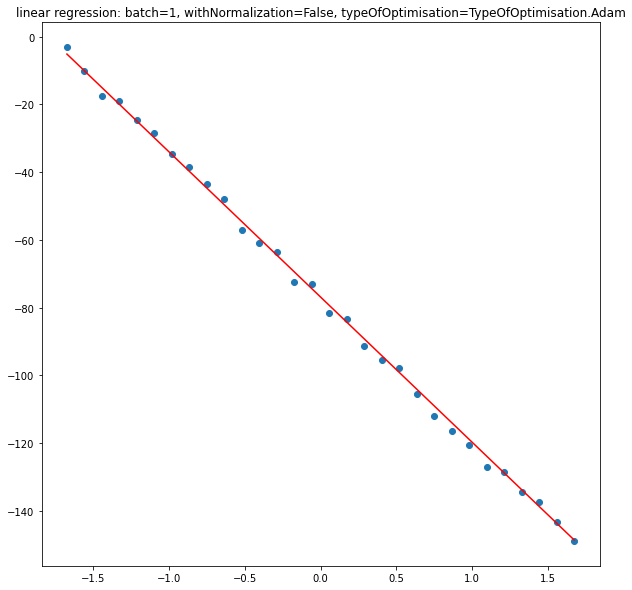

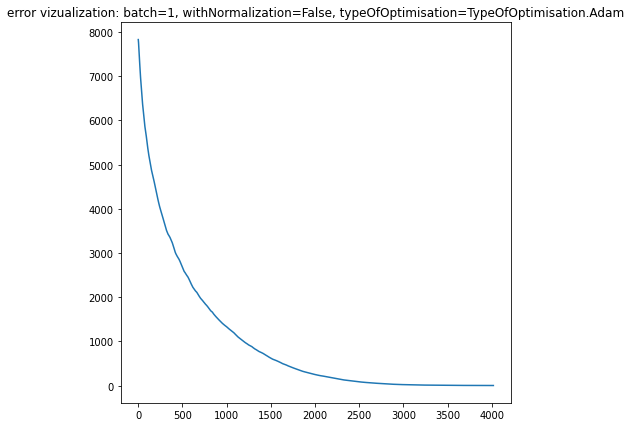

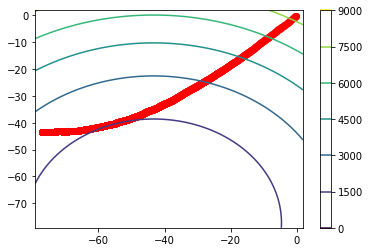

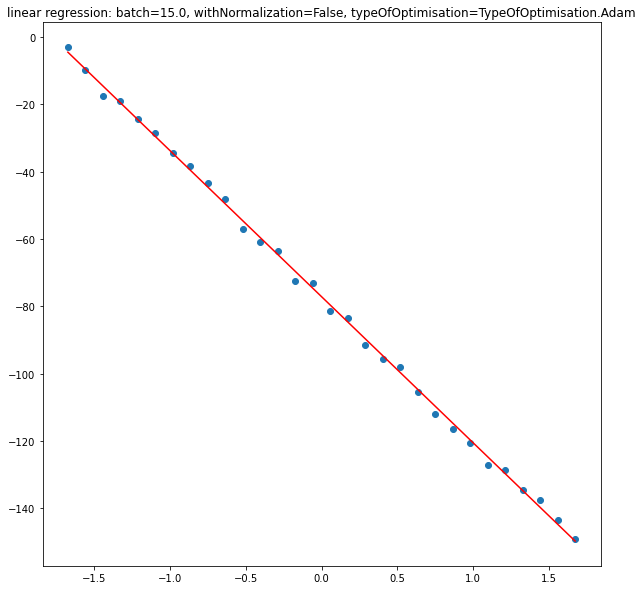

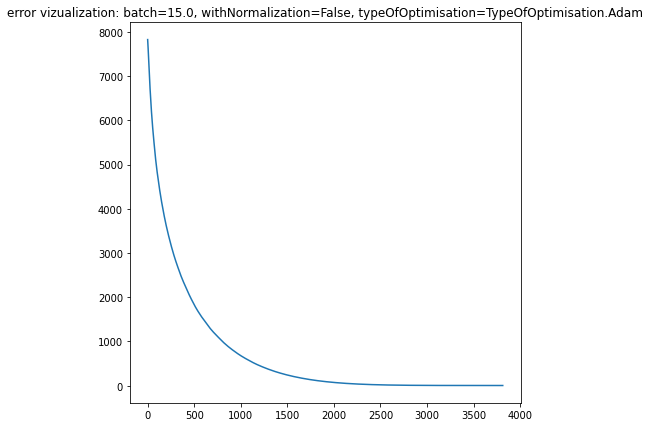

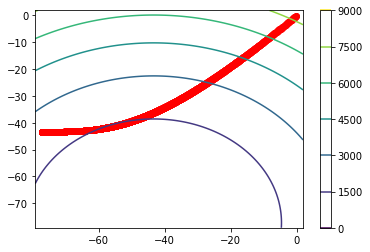

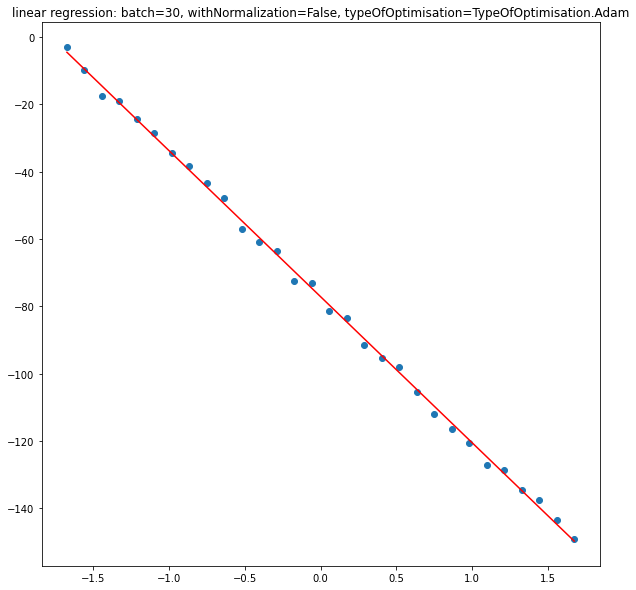

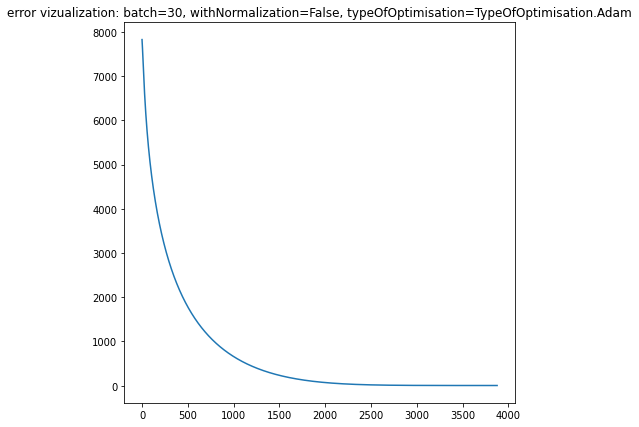

/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_5513/3645033361.py:35: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


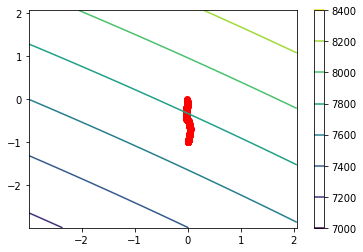

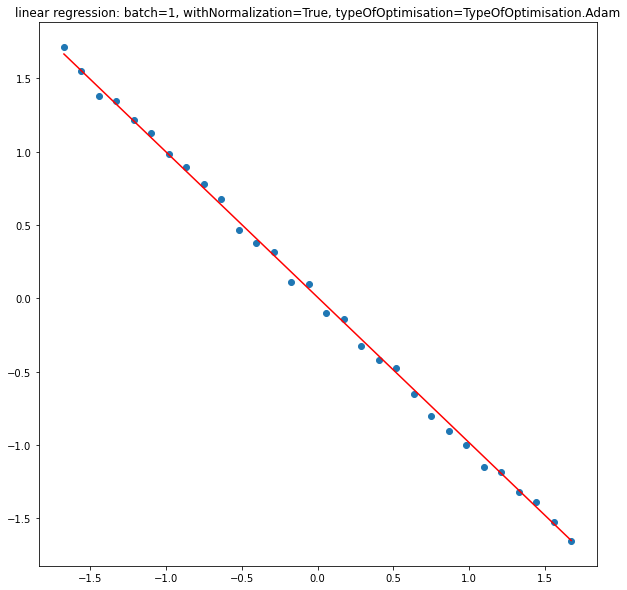

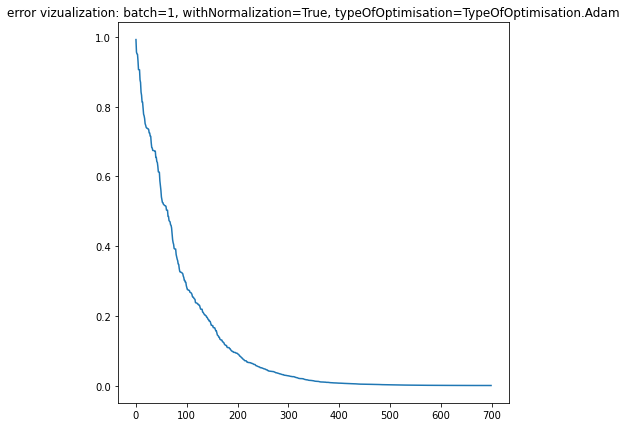

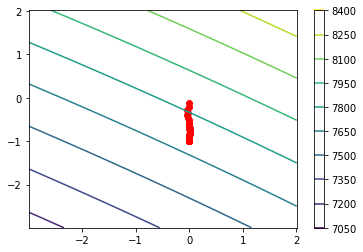

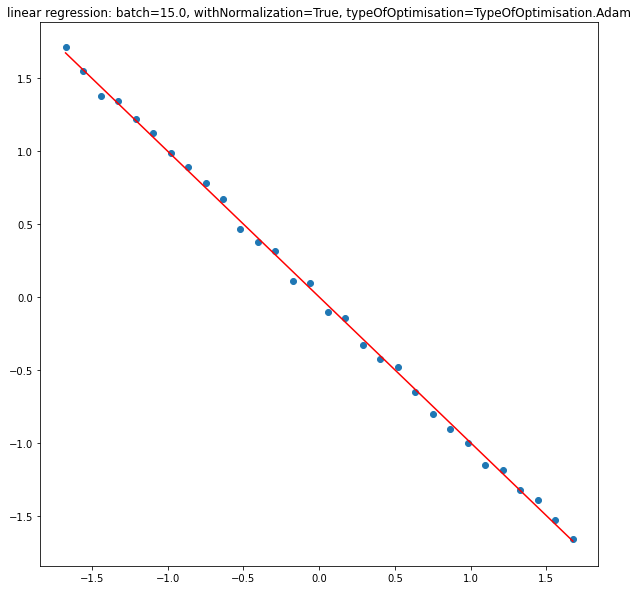

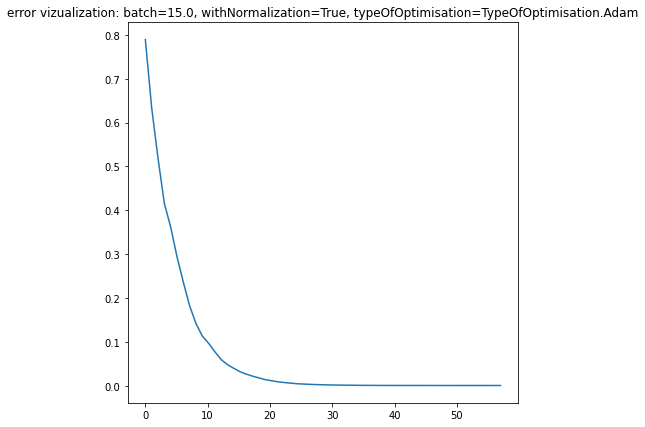

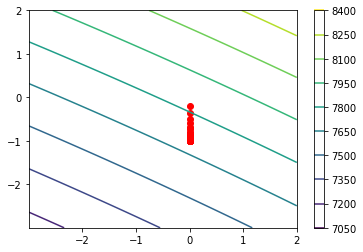

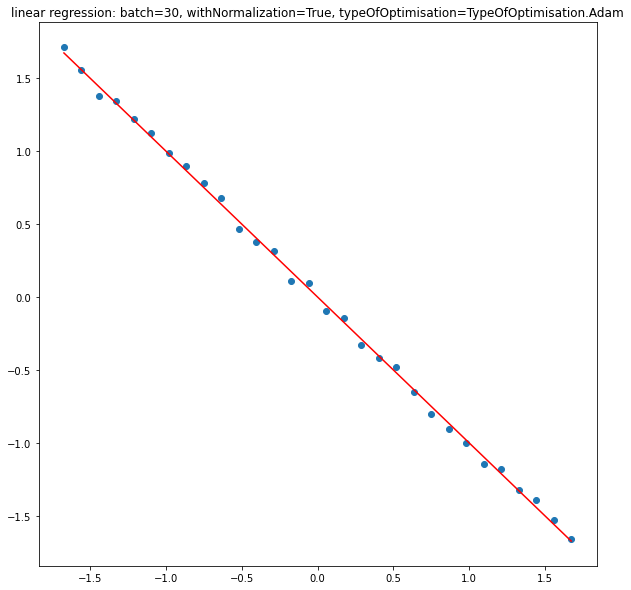

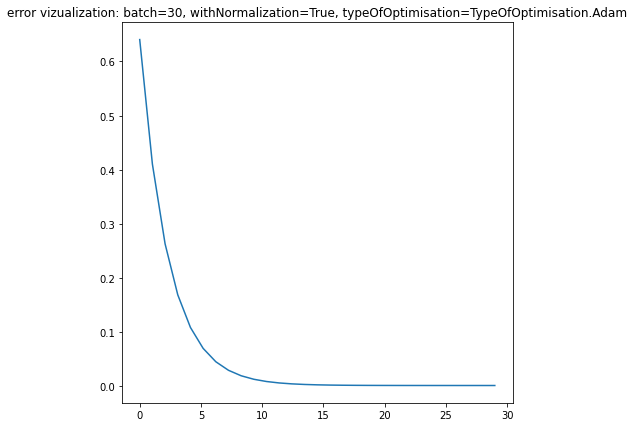

In [40]:
%memit runSGD(1, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M / 2, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(1, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-6)

# Задание 5

Чтобы построить линии уровня, необходимо посчитать сначала значения ошибки относительно сетки различных коэффициентов.
Мы внутри градиентного спуска генерируем массивы a, b от минимального до максимального возможного значения коэффициента.
Затем там же внутри градиентного спуска отмечаем точки, по которым ходил наш спуск, и получаем график.
Графики с линиями уровня строятся для каждого запуска спуска. Можно заметить зависимость между графиком изменения ошибки
и точками, отмеченными на линиях уровней функции: если ошибка изменялась плавно, то и спуск ходил плавно и наоборот -
если ошибка то больше, то меньше, то и спуск ходил из стороны в сторону.